In [88]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.time
import astropy.wcs
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.coordinates.sun import carrington_rotation_number
from sunpy.coordinates import propagate_with_solar_surface
from sunpy.coordinates.utils import solar_angle_equivalency
import zarr
import pfsspy
import asdf

import eispac.core

import synthesizAR
from synthesizAR.util import change_obstime, change_obstime_frame, from_pfsspy

import shapely
import descartes

import sys
sys.path.append('../pipeline')
from loop_selection import interpolate_hpc_coord, straight_loop_indices

# Loop Geometry

Extrapolate magnetic field, trace loops for selected region

First, load the reference images from EIS and AIA

In [10]:
m_eis = sunpy.map.Map('../pipeline/data/EIS/level_2.5/eis_20120924_105026.fe_12_195_119.2c-0.int.fits')

In [11]:
root = zarr.open('../pipeline/data/AIA/level_2/')
t_start = astropy.time.Time('2012-09-24 09:00:00')
cube_aia = ndcube.NDCube(root['171'][:],
                         wcs=astropy.wcs.WCS(root['171'].attrs['wcs']),
                         unit=root['171'].attrs['meta']['bunit'],
                         meta=root['171'].attrs['meta'],)
time_aia = cube_aia.axis_world_coords(0)[0] - cube_aia.axis_world_coords(0)[0][0] + t_start
index_eis = np.argmin(np.fabs((time_aia - m_eis.date_average).to_value('s')))
m_aia = sunpy.map.Map(cube_aia[index_eis,...].data, cube_aia.meta)

In [81]:
with asdf.open('../pipeline/static/traced-loop.asdf') as af:
    traced_loop = af.tree['loop']
traced_loop = interpolate_hpc_coord(traced_loop, 25)

In [248]:
m_aia = m_aia.submap(
    SkyCoord(Tx=m_aia.bottom_left_coord.Tx, Ty=0*u.arcsec, frame=m_aia.coordinate_frame),
    top_right=m_aia.top_right_coord,
)

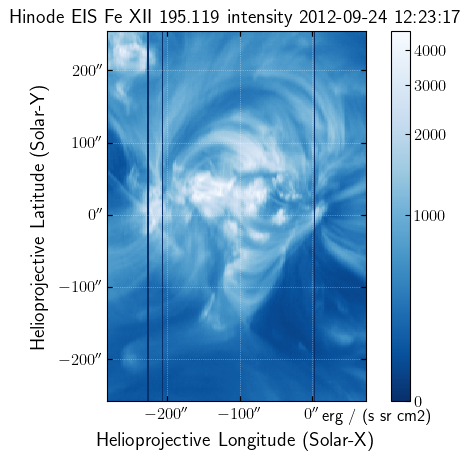

In [249]:
m_eis.peek()

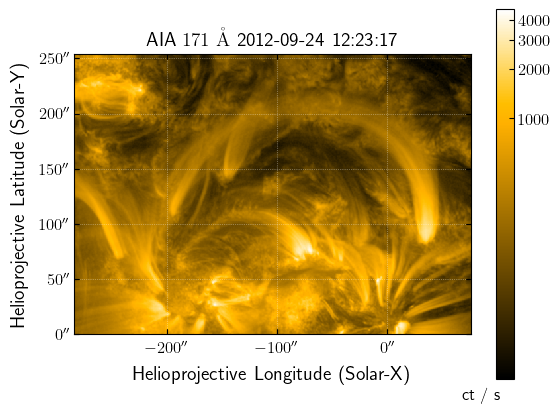

In [250]:
m_aia.peek()

In [414]:
m_aia.center.transform_to('heliographic_stonyhurst')

<SkyCoord (HeliographicStonyhurst: obstime=2012-09-24T12:23:17.500, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-6.43060507, 14.52797675, 6.957e+08)>

Get the relevant synoptic HMI magnetogram

In [15]:
car_rot = carrington_rotation_number(m_aia.date)

In [17]:
q = Fido.search(
    a.Time('2010/01/01', '2010/01/01'),
    a.jsoc.Series('hmi.synoptic_mr_polfil_720s'),
    a.jsoc.PrimeKey('CAR_ROT', int(car_rot)),
    a.jsoc.Notify('will.t.barnes@gmail.com')
)

In [19]:
file = Fido.fetch(q, path='model_data/')

Export request pending. [id=JSOC_20230915_313_X_IN, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20230915_313_X_IN, status=1]
Waiting for 5 seconds...
1 URLs found for download. Full request totalling 4MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

hmi.synoptic_mr_polfil_720s.2128.Mr_polfil.fits:   0%|          | 0.00/4.49M [00:00<?, ?B/s]

In [20]:
m_hmi = sunpy.map.Map(file)

Work out the bounding box of the AR in the coordinate frame of the synoptic magnetogram

In [251]:
blc_ar_synop = change_obstime(
    m_aia.bottom_left_coord.transform_to(
        change_obstime_frame(
            m_hmi.coordinate_frame, m_aia.date
        )
    ),
    m_hmi.date
)
trc_ar_synop = change_obstime(
    m_aia.top_right_coord.transform_to(
        change_obstime_frame(
            m_hmi.coordinate_frame, m_aia.date
        )
    ),
    m_hmi.date
)

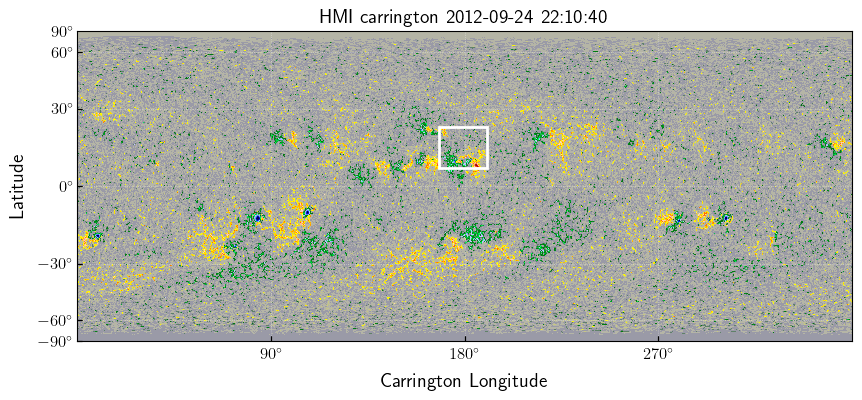

In [252]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=m_hmi)
m_hmi.plot(axes=ax)
m_hmi.draw_quadrangle(blc_ar_synop, top_right=trc_ar_synop)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


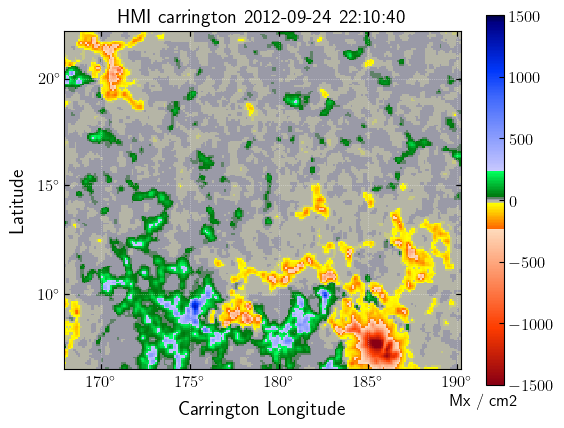

In [339]:
m_hmi.submap(blc_ar_synop, top_right=trc_ar_synop).peek()

Extrapolate magnetic field volume

In [367]:
m_hmi_resample.scale

SpatialPair(axis1=<Quantity 0.33333333 deg / pix>, axis2=<Quantity 0.21220659 deg / pix>)

In [376]:
m_hmi_resample = m_hmi.resample((1800,600)*u.pix)
print(m_hmi_resample.scale)

SpatialPair(axis1=<Quantity 0.2 deg / pix>, axis2=<Quantity 0.19098593 deg / pix>)


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


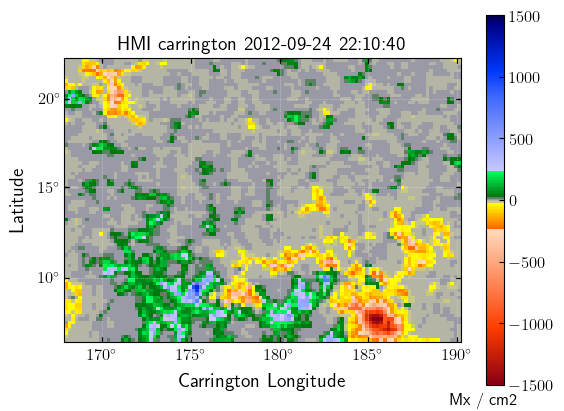

In [377]:
m_hmi_resample.submap(blc_ar_synop, top_right=trc_ar_synop).peek()

In [378]:
nrho = 70
rss = 2.5
pfss_input = pfsspy.Input(m_hmi_resample, nrho, rss, )

In [379]:
pfss_output = pfsspy.pfss(pfss_input)

Choose seedpoints randomly distributed across the active region and trace fieldlines

In [381]:
# This searches the (non-integer) pixel coordinates
num_seeds = 20000
pix_blc = m_hmi_resample.wcs.world_to_pixel(blc_ar_synop)
pix_trc = m_hmi_resample.wcs.world_to_pixel(trc_ar_synop)
pixel_random = np.random.uniform(low=pix_blc, high=pix_trc, size=(num_seeds,2)).T
seeds = m_hmi_resample.wcs.pixel_to_world(*pixel_random).make_3d()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


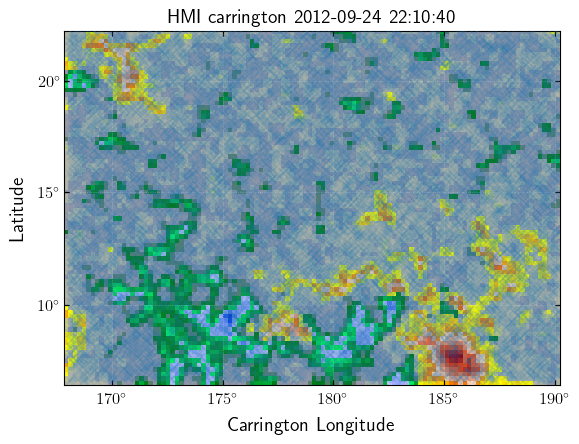

In [382]:
m_hmi_sub = m_hmi_resample.submap(blc_ar_synop, top_right=trc_ar_synop)
fig = plt.figure()
ax = fig.add_subplot(projection=m_hmi_sub)
m_hmi_sub.plot(axes=ax)
ax.plot_coord(seeds, marker='x', color='C0', alpha=0.1)

In [383]:
ds = 0.05
max_steps = int(np.ceil(2 * nrho / ds))
tracer = pfsspy.tracing.FortranTracer(step_size=ds, max_steps=max_steps)
fieldlines = tracer.trace(SkyCoord(seeds), pfss_output,)

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 2800) and try again.
  warnings.warn(


Convert strands to `Loop` objects.
We set the minimum allowed loop length using the projected arc length of our traced strand.
This is just a lower bound as the actual three dimensional structure is likely much longer

In [384]:
length_min = traced_loop.separation(traced_loop[0]).to('arcsec')[-1].to(
    'Mm',
    equivalencies=solar_angle_equivalency(traced_loop.observer),
)

INFO: Apparent body location accounts for 500.50 seconds of light travel time [sunpy.coordinates.ephemeris]


In [458]:
strands = from_pfsspy(fieldlines.closed_field_lines,
                      n_min=10,
                      obstime=m_aia.date,
                      length_min=length_min*1.2,
                      length_max=500*u.Mm,
                      cross_sectional_area=1e17*u.cm**2)

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'


In [459]:
with propagate_with_solar_surface():
    strands = [synthesizAR.Loop(l.name,
                                l.coordinate.transform_to(m_aia.observer_coordinate.frame),
                                field_strength=l.field_strength,
                                cross_sectional_area=l.cross_sectional_area)
               for l in strands]

In [460]:
len(strands)

798

(1.56052948341312e-12, 423.0000000000119)

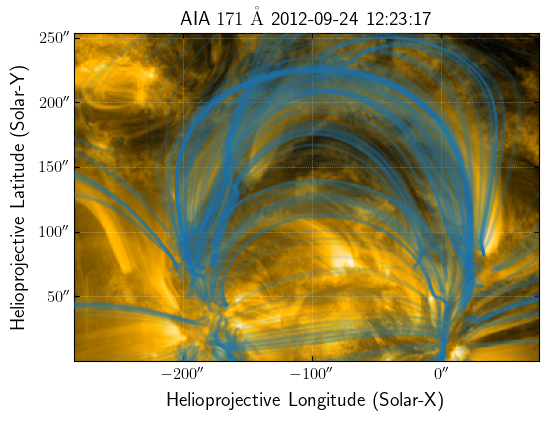

In [461]:
fig = plt.figure(figsize=(6,9))
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
for s in strands:
    ax.plot_coord(s.coordinate, color='C0', alpha=0.1)
xmin,ymin = m_aia.wcs.world_to_pixel(m_aia.bottom_left_coord)
xmax,ymax = m_aia.wcs.world_to_pixel(m_aia.top_right_coord)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

Now, we need to find the strands that approximately correspond to our visually identified coronal loop.

In [462]:
_, _, indices = straight_loop_indices(traced_loop, 45*u.arcsec, m_aia.wcs)

In [463]:
traced_loop_polygon = shapely.Polygon(np.concatenate((
    indices[0,...],
    indices[:,-1,:],
    indices[-1,...],
    indices[::-1,0,:],
)).tolist()).buffer(0)

In [464]:
overlap_tol = 0.7
overlap_strands = []
for s in strands:
    strand_polygon = shapely.LineString(
        np.array(m_aia.wcs.world_to_pixel(s.coordinate)).T.tolist())
    intersection = traced_loop_polygon.intersection(strand_polygon)
    if intersection.length / strand_polygon.length >= overlap_tol:
        overlap_strands.append(s)

In [465]:
len(overlap_strands)

47

(1.56052948341312e-12, 423.0000000000119)

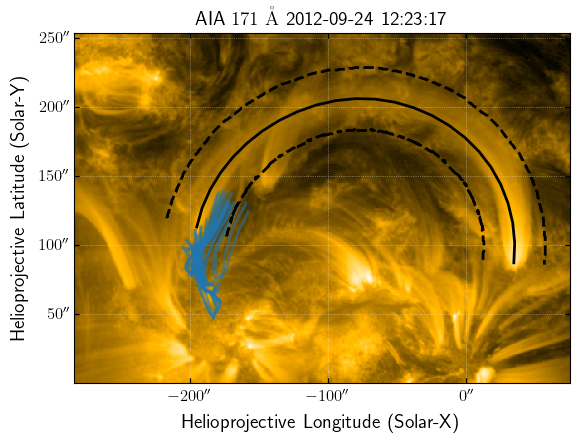

In [473]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
for s in overlap_strands:
    ax.plot_coord(s.coordinate[:100], color='C0', alpha=0.5)
ax.plot_coord(traced_loop, color='k')
ax.plot_coord(m_aia.wcs.pixel_to_world(*indices[:,0,:].T), color='k', ls='--')
ax.plot_coord(m_aia.wcs.pixel_to_world(*indices[:,-1,:].T), color='k', ls='--')
xmin,ymin = m_aia.wcs.world_to_pixel(m_aia.bottom_left_coord)
xmax,ymax = m_aia.wcs.world_to_pixel(m_aia.top_right_coord)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

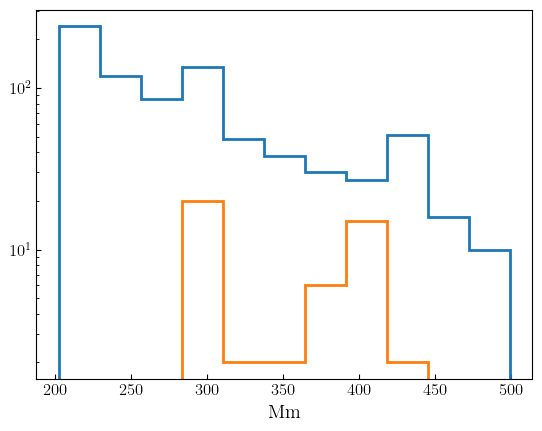

In [467]:
with quantity_support():
    _,bin_edges,_ = plt.hist(u.Quantity([s.length for s in strands]).to('Mm'), bins='scott', histtype='step')
    plt.hist(u.Quantity([so.length for so in overlap_strands]).to('Mm'), bins=bin_edges, histtype='step');
    plt.yscale('log')

Refine loops such that they're well below the AIA resolution

In [468]:
target_res = 0.6*u.arcsec/u.pix
delta_s = (target_res*(1*u.pix)/2).to(
    'Mm', equivalencies=solar_angle_equivalency(m_aia.observer_coordinate))

INFO: Apparent body location accounts for 500.50 seconds of light travel time [sunpy.coordinates.ephemeris]


In [469]:
skeleton = synthesizAR.Skeleton(overlap_strands).refine_loops(delta_s, prepkwargs={'k':1})

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:194: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


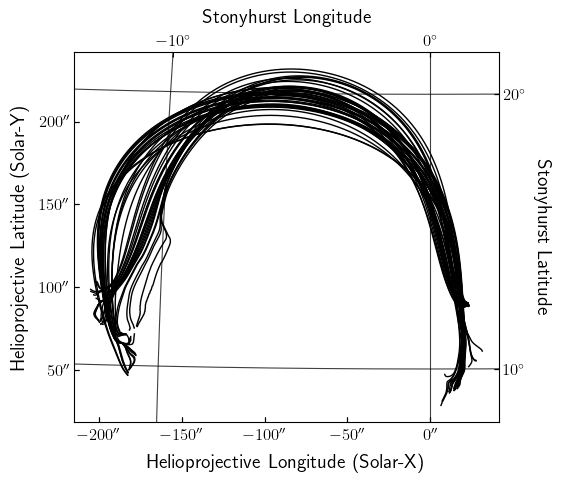

In [470]:
skeleton.peek(observer=m_aia.observer_coordinate)

In [471]:
skeleton.to_asdf('model_data/base_skeleton.asdf')

Do a quick AIA synthetic image to ensure everything looks approximately sensible

In [448]:
from synthesizAR.interfaces import MartensInterface
from synthesizAR.instruments import InstrumentSDOAIA

In [449]:
rtv_model = MartensInterface(1e-5*u.Unit('erg cm-3 s-1'))

In [450]:
skeleton.load_loop_simulations(rtv_model)

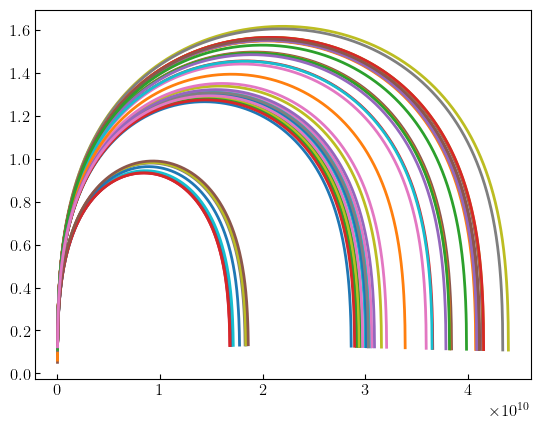

In [451]:
for l in skeleton.loops:
    plt.plot(l.field_aligned_coordinate_center, l.electron_temperature.squeeze().to('MK'))

In [452]:
aia = InstrumentSDOAIA([0,1]*u.s, m_aia.observer_coordinate, pad_fov=[10,10]*u.arcsec)

In [453]:
maps = aia.observe(skeleton)

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:194: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:194: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


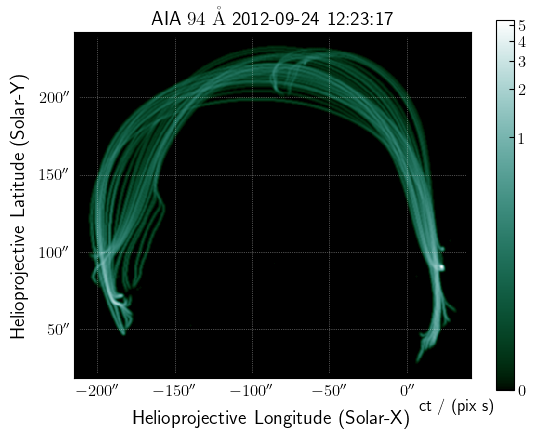

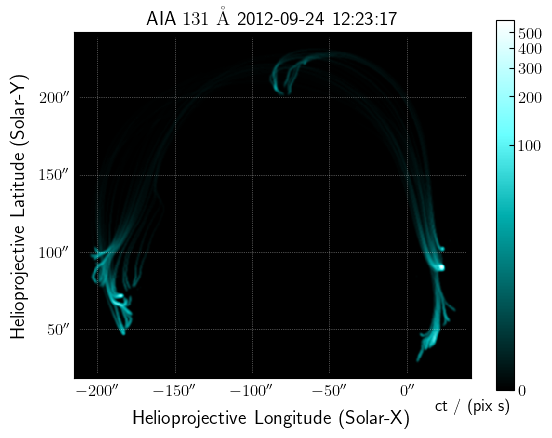

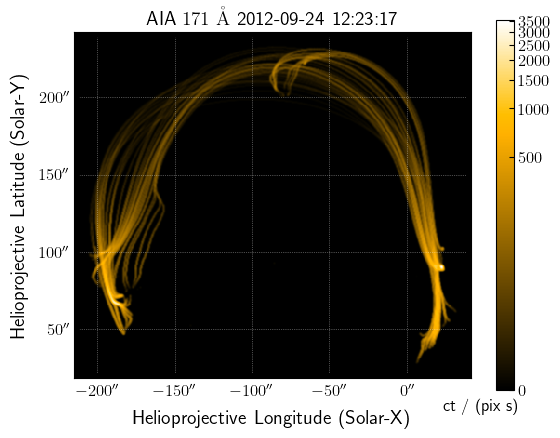

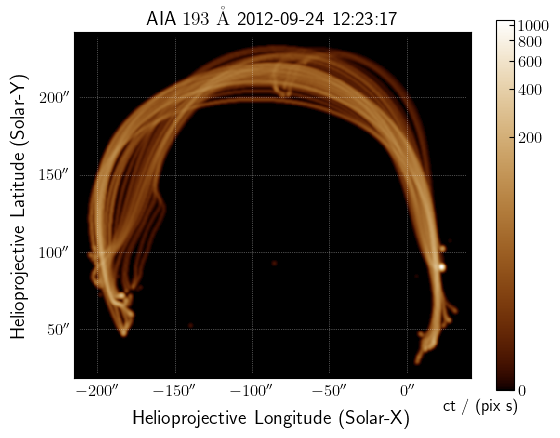

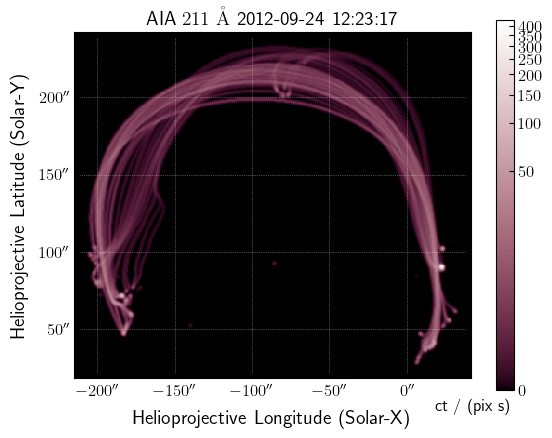

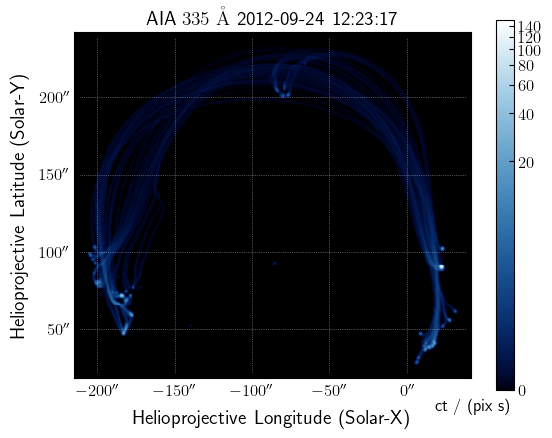

In [454]:
for k in maps:
    maps[k][0].peek()